<a href="https://colab.research.google.com/github/rsreds/Colabs/blob/master/ScanAnswer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install img2table


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 52.3 MB/s eta 0:00:00


In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from img2table.document import Image


In [56]:
number_of_tables = 1
questions_per_table =  10
filename = "/content/file.jpg"

In [57]:
doc = Image(filename)
extracted_tables = doc.extract_tables(implicit_rows=False)

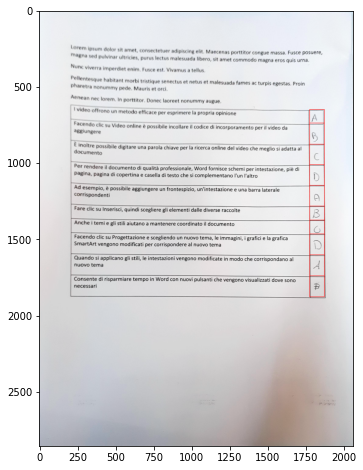

In [58]:
# Display extracted tables
img = cv2.imread(filename)
answers_bb = [row[-1].bbox for row in extracted_tables[0].content.values()]
for answer in answers_bb:
    cv2.rectangle(img, (answer.x1, answer.y1), (answer.x2, answer.y2), (255, 0, 0), 2)
plt.figure(figsize=(20,8))            
plt.imshow(img);

In [59]:
!pip install emnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [190]:
from emnist import extract_training_samples, extract_test_samples

In [191]:
X_train,y_train = extract_training_samples('balanced') # balanced dataset merges capital and lowercase letters only when the difference is minimal (C-c J-j O-o )
X_test,y_test = extract_test_samples('balanced')
classes = ['a', 'b', 'c', 'd'] # Classes 0-9 are for digits, 10 11 12 13
number_of_classes = len(classes)

In [192]:
filter_train = (y_train < (10 + number_of_classes)) & (y_train > 9)
filter_test = (y_test < (10 + number_of_classes)) & (y_test > 9)

In [193]:
y_train = y_train[filter_train]
X_train = X_train[filter_train]
y_test = y_test[filter_test]
X_test = X_test[filter_test]

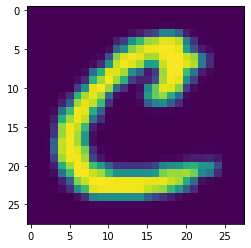

In [194]:
plt.imshow(X_train[1])

In [195]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

In [196]:
y_train = tf.keras.utils.to_categorical(y_train-10, number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test-10, number_of_classes)

In [197]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(32,3,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(number_of_classes,activation='softmax')
])

In [198]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [199]:
MCP = ModelCheckpoint('Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

In [200]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),callbacks=[MCP,ES,RLP])

Epoch 1/10
288/300 [===========================>..] - ETA: 0s - loss: 8.6994 - accuracy: 0.8812
Epoch 1: val_accuracy improved from -inf to 0.94687, saving model to Best_points.h5
300/300 [==============================] - 3s 5ms/step - loss: 8.3663 - accuracy: 0.8842 - val_loss: 0.3786 - val_accuracy: 0.9469 - lr: 0.0010
Epoch 2/10
299/300 [============================>.] - ETA: 0s - loss: 0.2563 - accuracy: 0.9576
Epoch 2: val_accuracy did not improve from 0.94687
300/300 [==============================] - 1s 5ms/step - loss: 0.2561 - accuracy: 0.9575 - val_loss: 0.4924 - val_accuracy: 0.9469 - lr: 0.0010
Epoch 3/10
294/300 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9746
Epoch 3: val_accuracy did not improve from 0.94687
300/300 [==============================] - 2s 6ms/step - loss: 0.1606 - accuracy: 0.9744 - val_loss: 0.4406 - val_accuracy: 0.9469 - lr: 0.0010
Epoch 4/10
296/300 [============================>.] - ETA: 0s - loss: 0.0978 - accuracy: 0.983

In [201]:
import imutils

def resize_and_fill(image, width, height):
    img = image.astype(np.uint8)
    _,img = cv2.threshold(img,50,255,cv2.THRESH_OTSU)
    contours,hierarchy = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)

    crop = img[y:y+h,x:x+w]
    padded = cv2.copyMakeBorder(crop, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    (original_height, original_width) = padded.shape[:2]

    blank_image = np.zeros((width,height), np.uint8)
    blank_image[:,:] = (0)

    if original_width > original_height:
        ratio = width / float(original_width)
        dim = (width, int(original_height*ratio))
    else:
        ratio = height / float(original_height)
        dim = (int(original_width*ratio), height)
    image = cv2.resize(padded, dim,  cv2.INTER_CUBIC)

    x_offset = (width-image.shape[1])//2
    y_offset = (height-image.shape[0])//2
    blank_image[y_offset:y_offset+image.shape[0], x_offset:x_offset+image.shape[1]] = image.copy()
    return blank_image


def preprocess(image):
    image = cv2.normalize(image, None, 0, 255.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    image = resize_and_fill(image, 28, 28)
    return image

In [202]:
img = cv2.bitwise_not(cv2.imread(filename, cv2.IMREAD_GRAYSCALE))
answers = [img[abb.y1+10:abb.y2-10,abb.x1+10:abb.x2-10] for abb in answers_bb]

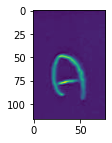

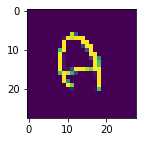

In [203]:
plt.figure(figsize=(2,2))
plt.imshow(answers[4])
plt.figure(figsize=(2,2))
plt.imshow(preprocess(answers[4]))

In [204]:
answers = np.array([preprocess(ans) for ans in answers])
# answers = np.array([answers])
answers.shape

(10, 28, 28)

In [205]:
ans_prob = model.predict(answers)
ans_class = ans_prob.argmax(axis=-1)

1/1 [==============================] - 0s 64ms/step


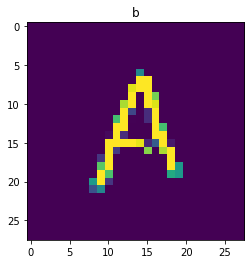

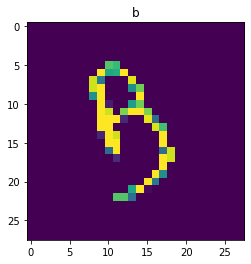

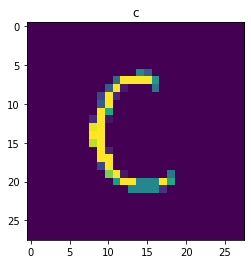

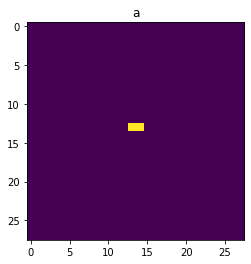

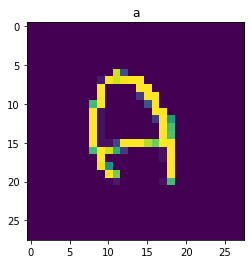

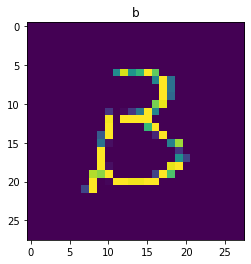

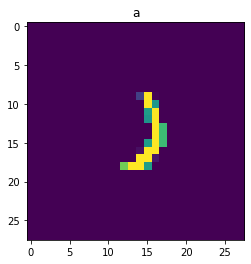

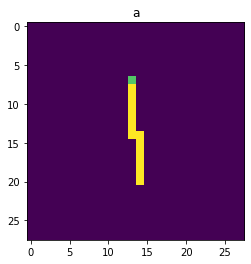

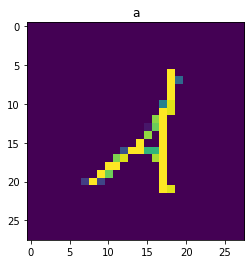

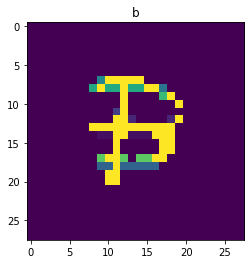

In [206]:
for i in range(10):
    plt.figure()
    plt.imshow(answers[i])
    plt.title(classes[ans_class[i]])

In [208]:
ans_prob[0]


array([1.11628465e-01, 8.88371527e-01, 3.53614082e-11, 4.95228442e-11],
      dtype=float32)